# Homework 3: optimization of a CNN model
The task of this homework is to optimize a CNN model for the CIFAR-100. You are free to define the architecture of the model, and the training procedure. The only contraints are:
- It must be a `torch.nn.Module` object
- The number of trained parameters must be less than 1 million
- The test dataset must not be used for any step of training.
- The final training notebook should run on Google Colab within a maximum 1 hour approximately.
- Do not modify the random seed, as they are needed for reproducibility purpose.

For the grading, you must use the `evaluate` function defined below. It takes a model as input, and returns the test accuracy as output.

As a guideline, you are expected to **discuss** and motivate your choices regarding:
- Model architecture
- Hyperparameters (learning rate, batch size, etc)
- Regularization methods
- Optimizer
- Validation scheme

A code without any explanation of the choices will not be accepted. Test accuracy is not the only measure of success for this homework.

Remember that most of the train process is randomized, store your model's weights after training and load it before the evaluation!

## Example

### Loading packages and libraries

In [1]:
#--- Preventing potential library conflicts on my Windows machine---#
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
import random
import numpy as np
import torch
import torchvision


# Fix all random seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# For full determinism
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Import the best device available
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu')
print('Using device:', device)

# load the data
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())

Using device: cuda


In [3]:
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

def evaluate(model):
    params_count = sum(p.numel() for p in model.parameters())
    print('The model has {} parameters'.format(params_count))

    if params_count > int(1e6):
        print('The model has too many parameters! Not allowed to evaluate.')
        return

    model = model.to(device)
    model.eval()
    correct = 0
    total = 0

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    # print in bold red in a notebook
    print('\033[1m\033[91mAccuracy on the test set: {}%\033[0m'.format(100 * correct / total))


### Example of a simple CNN model

In [3]:
class TinyNet(torch.nn.Module):
    def __init__(self):
        super(TinyNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(8*8*64, 128)
        self.fc2 = torch.nn.Linear(128, 100)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 8*8*64)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

print("Model parameters: ", sum(p.numel() for p in TinyNet().parameters()))

Model parameters:  556708


### Example of basic training

In [4]:

model = TinyNet()
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
for epoch in range(10):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 10, loss.item()))


Epoch [1/10], Loss: 4.6139
Epoch [2/10], Loss: 4.5809
Epoch [3/10], Loss: 4.5755
Epoch [4/10], Loss: 4.5898
Epoch [5/10], Loss: 4.5963
Epoch [6/10], Loss: 4.5981
Epoch [7/10], Loss: 4.6149
Epoch [8/10], Loss: 4.5327
Epoch [9/10], Loss: 4.5011
Epoch [10/10], Loss: 4.3966


In [ ]:
# save the model on a file
torch.save(model.state_dict(), 'tiny_net.pt')

loaded_model = TinyNet()
loaded_model.load_state_dict(torch.load('tiny_net.pt', weights_only=True))
evaluate(loaded_model)

The model has 556708 parameters
Accuracy on the test set: 3.4%


: 

## My TinyResNet

In [4]:
# Define functions needed, copy from training_utils.py of course material TP10
# import everything else that we need
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from typing import Optional


def train_epoch(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
):
    """
    This function implements the core components of any Neural Network training regiment.
    In our stochastic setting our code follows a very specific "path". First, we load the batch
    a single batch and zero the optimizer. Then we perform the forward pass, compute the gradients and perform the backward pass. And ...repeat!
    """

    running_loss = 0.0
    model = model.to(device)
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        # move data and target to device
        data, target = data.to(device), target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # do the forward pass
        output = model(data)

        # compute the loss
        # loss = F.cross_entropy(output, target)
        loss = F.cross_entropy(output, target, label_smoothing=0.1)

        # compute the gradients
        loss.backward()

        # perform the gradient step
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    return running_loss / len(train_dataloader)


def fit(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
):
    """
    the fit method simply calls the train_epoch() method for a
    specified number of epochs.
    """

    # keep track of the losses in order to visualize them later
    losses = []
    for epoch in range(epochs):
        running_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            device=device,
        )
        print(f"Epoch {epoch}: Loss={running_loss}")
        losses.append(running_loss)

    return losses


def predict(
    model: nn.Module, test_dataloader: DataLoader, device: torch.device, verbose=True
):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target, reduction="sum")
            test_loss += loss.item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_dataloader.dataset)
    accuracy = 100.0 * correct / len(test_dataloader.dataset)

    if verbose:
        print(
            f"Test set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_dataloader.dataset)} ({accuracy:.0f}%)"
        )

    return test_loss, accuracy


def visualize_images(dataloader):
    images = next(iter(dataloader))[0][:10]
    grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

    def show(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")

    show(grid)


def plot_loss(losses, ylim=None):
    plt.plot(losses)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.ylim(ylim)
    plt.title("Loss progression across epochs")


In [5]:
# define the hyperparameters
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 1024
LEARNING_RATE = 0.01

# find out which device is available
DEVICE = None
if torch.cuda.is_available():
    # Requires NVIDIA GPU with CUDA installed
    DEVICE = torch.device("cuda")
elif torch.mps.is_available():
    # Requires Apple computer with M1 or later chip
    DEVICE = torch.device("mps")
else:
    # Not recommended, because it's slow. Move to Google Colab!
    DEVICE = torch.device("cpu")

print(DEVICE)

cuda


In [6]:
# First we load all the necessary libraries
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F


# Data Argumentation
# CIFAR-10 Mean and Std
# These values are commonly used for CIFAR-10 normalization
stats = ((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))


# 1. Define transformations for data augmentation (applied only to the training set)
# Includes: random cropping, random horizontal flipping, conversion to Tensor, and normalization
train_transform_augmented = transforms.Compose([
    transforms.RandomCrop(32, padding=4),       # Randomly crop the image after padding it with 4 pixels on all sides
    transforms.RandomHorizontalFlip(),          # Horizontally flip the image with a 50% probability
    transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10), # AutoAugment
    transforms.ToTensor(),                      # Mandatory step: convert the image to a PyTorch Tensor
    # Normalize using the standard mean and standard deviation for the CIFAR-10 dataset
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 2. Define transformations for the test set (typically no augmentation, but normalization is advised to match the training data)
test_transform_normalized = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 3. [Crucial Step] Directly overwrite the 'transform' attribute of the original dataset object
# This ensures that the train_dataloader automatically applies the new augmentation strategy when fetching data
train_dataset.transform = train_transform_augmented
test_dataset.transform = test_transform_normalized

print("Data augmentation has been applied to train_dataset.transform")


train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2)



Data augmentation has been applied to train_dataset.transform


In [7]:
# Fit function with scheduler (Reference from TP10)
def fit_scheduler(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = None # Scheduler
):
    losses = []
    for epoch in range(epochs):
        running_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            device=device,
        )
        print(f"Epoch {epoch}: Loss={running_loss}")
        losses.append(running_loss)

        if scheduler is not None:
            scheduler.step() 

    return losses

In [8]:
# Tiny ResNet Model (Reference from TP10)

class TinyResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100): # CHANGE: Default classes to 100
        super().__init__()
        # CHANGE: Reduce initial channels from 64 to 32 to save parameters
        self.in_planes = 32 

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        
        # CHANGE: We only keep 3 layers. 
        # Layer 1: 32 channels
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        # Layer 2: 64 channels
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        # Layer 3: 128 channels
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        
        # CHANGE: Removed layer4 (256/512 channels) because it consumes too many parameters
        
        # CHANGE: Linear layer input is now 128 (output of layer3)
        self.linear = nn.Linear(128, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out) # REMOVED
        
        # CHANGE: Global Average Pooling (Adaptive ensures 1x1 output regardless of input size)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    

class CorrectBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):

        # 1. Preserve the input data to serve as the residual (shortcut) connection.
        # It automatically adjusts dimensions if they mismatch; otherwise, it remains an identity mapping (passing x directly).
        residual = self.shortcut(x)

        # 2. Main Path: Execute standard convolution operations.
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # 3. Core Step: Add the output from the main path to the residual from the shortcut connection.
        out += residual 

        # 4. Apply the final ReLU activation function.
        out = F.relu(out)

        return out

In [9]:
# Re-initialize the model to start fresh
model = TinyResNet(block=CorrectBlock, num_blocks=[2,2,2]).to(DEVICE)

# Define the optimizer (SGD with momentum is standard for ResNets)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Define the Scheduler
# This will multiply the LR by 0.1 at epoch 15 and again at epoch 25
# scheduler = torch.optim.lr_scheduler.MultiStepLR(
#     optimizer, 
#     milestones=[30, 50], 
#     gamma=0.1
# )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=60)

print("Model parameters: ", sum(p.numel() for p in model.parameters()))

Model parameters:  708228


In [10]:
# Train using the fit_scheduler function
# Make sure to use fit_scheduler, not just fit, so the LR updates happen!
train_losses = fit_scheduler(
    model=model,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=60, # again, 60 epochs due to data augmentation
    device=DEVICE,
    scheduler=scheduler
)

Epoch 0: Loss=4.386505866537289
Epoch 1: Loss=4.122163393059555
Epoch 2: Loss=3.9369625655972227
Epoch 3: Loss=3.7838287499486185
Epoch 4: Loss=3.6249174487834073
Epoch 5: Loss=3.452512960044705
Epoch 6: Loss=3.3506851196289062
Epoch 7: Loss=3.1916465856591048
Epoch 8: Loss=3.0702027155428517
Epoch 9: Loss=2.990234355537259
Epoch 10: Loss=2.9006363810325158
Epoch 11: Loss=2.824263796514394
Epoch 12: Loss=2.7646097601676476
Epoch 13: Loss=2.7089332853044783
Epoch 14: Loss=2.6535578114645824
Epoch 15: Loss=2.6094708150746873
Epoch 16: Loss=2.5650940573945338
Epoch 17: Loss=2.515693051474435
Epoch 18: Loss=2.4844201681565266
Epoch 19: Loss=2.4435496719516054
Epoch 20: Loss=2.41123873360303
Epoch 21: Loss=2.3754667116671193
Epoch 22: Loss=2.3455662046160017
Epoch 23: Loss=2.3335095084443385
Epoch 24: Loss=2.300577484831518
Epoch 25: Loss=2.2661081771461333
Epoch 26: Loss=2.24845721770306
Epoch 27: Loss=2.2317495297412484
Epoch 28: Loss=2.2023681913103377
Epoch 29: Loss=2.175903860403567
Ep

Test set: Avg. loss: 1.1840, Accuracy: 6844/10000 (68%)


(1.1840345947265625, tensor(68.4400, device='cuda:0'))

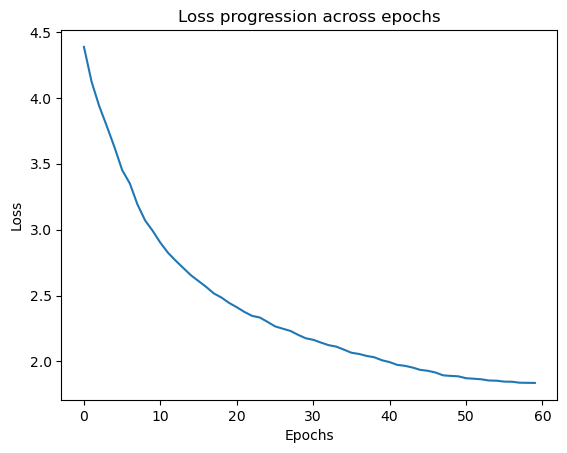

In [11]:
# Plot the training loss
plot_loss(train_losses)

# Evaluate on the test set
predict(
    model,
    test_dataloader=test_dataloader,
    device=DEVICE
)